In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

from torch.utils.data import DataLoader, TensorDataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [2]:
df = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv')
df.head()

,Date,Open,Close,Change,sentiment,sentiment_score
0,2025-01-10,3761.549,3736.886,-0.66,0,0.700804
1,2024-12-19,3780.106,3708.531,-1.93,0,0.950467
2,2024-12-18,3774.744,3781.551,0.18,1,0.460880
3,2024-12-16,3748.220,3765.163,0.45,1,0.771217
4,2024-12-12,3744.519,3748.267,0.10,1,0.927686


In [3]:

# Convert 'Date' column to datetime objects if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Select features and target variable
features = ['Open', 'sentiment_score'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [4]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

In [5]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)


Epoch 1/50
11/11 [==============================] - 3s 7ms/step - loss: 0.0980
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 6/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 11/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 12/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0086
Epoch 13/50
11/11 [==============================

3/3 [==============================] - 1s 4ms/step
Test Loss (MSE): 0.0051467763260006905
Mean Absolute Error (MAE): 24.281109486273824
R-squared (R2): 0.8262852216633121


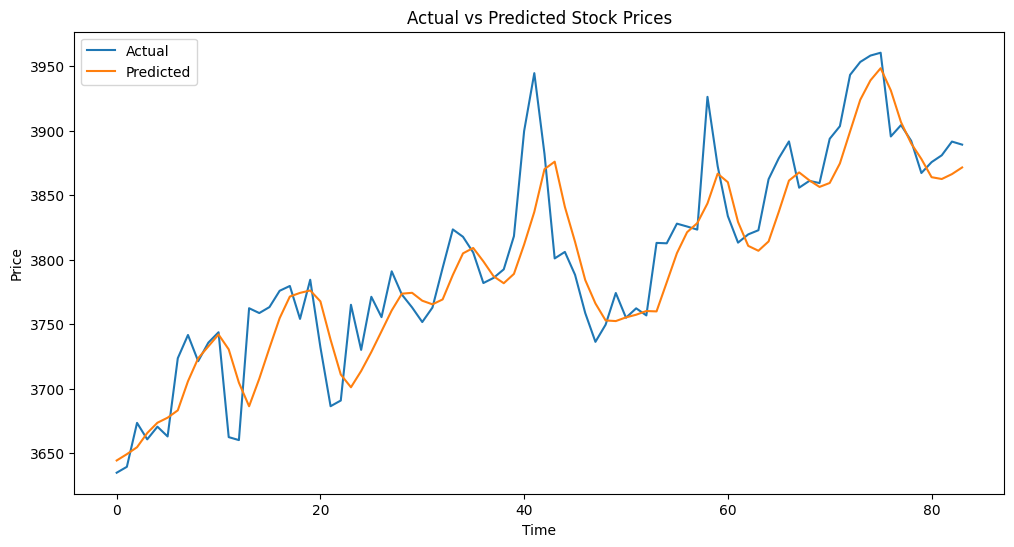

In [6]:
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

In [7]:
# Assuming 'df' is your DataFrame
# Select relevant columns and convert the 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Date', 'Close']]
data = data.set_index('Date')

# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the data for the CNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Example sequence length
X, y = create_sequences(data['Close'].values, seq_length)

# Reshape data for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)


# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model 
model.fit(X, y, epochs=100, batch_size=32, verbose=10) # Adjust epochs and batch size as needed


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

14/14 [==============================] - 0s 1ms/step - loss: 0.0043
Test Loss: 0.00431275786831975
Mean Absolute Error (MAE): 21.85929888872314
R-squared (R2): 0.8972190791839845


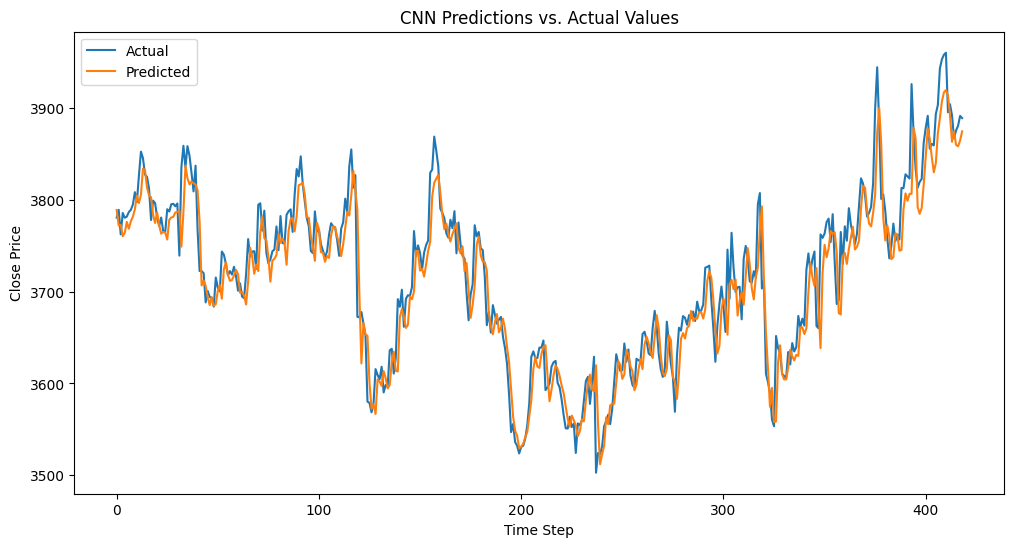

In [8]:
predictions = model.predict(X)

# Inverse transform the predictions and actual values to get original scale
predictions = scaler.inverse_transform(predictions)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

# print loss
loss = model.evaluate(X, y)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_original, predictions)

# Calculate the R-squared (R2)
r2 = r2_score(y_original, predictions)

# Print the results
print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()

# CNN-LSTM

Epoch 1/200
11/11 [==============================] - 4s 5ms/step - loss: 0.1045
Epoch 2/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0140
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 7/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 8/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 9/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 10/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0101
Epoch 11/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 12/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0095
Epoch 13/200
11/11 [=================

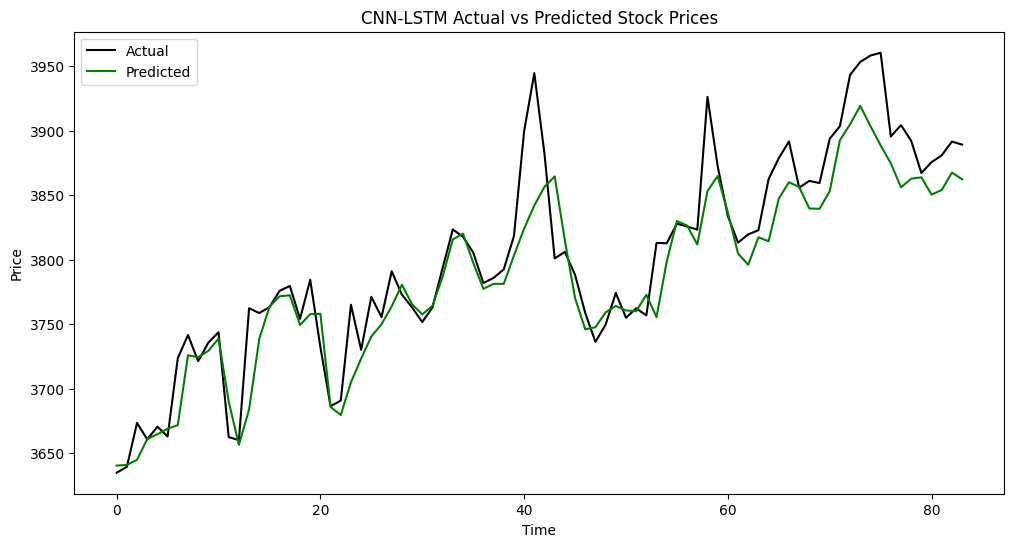

In [9]:
# Reshape data for CNN-LSTM input
X_train_cnn_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Build the CNN-LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, X_train.shape[2])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=50, return_sequences=True))
cnn_lstm_model.add(LSTM(units=50))
cnn_lstm_model.add(Dense(units=1))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
cnn_lstm_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

# Evaluate the model on test data
cnn_lstm_loss = cnn_lstm_model.evaluate(X_test, y_test)

# Predict on the test data
cnn_lstm_y_pred = cnn_lstm_model.predict(X_test)

# Inverse transform the scaled data to get actual prices
cnn_lstm_y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
cnn_lstm_y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], cnn_lstm_y_pred.reshape(-1, 1)), axis=1))[:, -1]

cnn_lstm_mae = mean_absolute_error(cnn_lstm_y_test_actual, cnn_lstm_y_pred_actual)

# Calculate R-squared (R2)
cnn_lstm_r2 = r2_score(cnn_lstm_y_test_actual, cnn_lstm_y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {cnn_lstm_loss}")
print(f"Mean Absolute Error (MAE): {cnn_lstm_mae}")
print(f"R-squared (R2): {cnn_lstm_r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(cnn_lstm_y_test_actual, label='Actual', color='black')
plt.plot(cnn_lstm_y_pred_actual, label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('CNN-LSTM Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# CNN-LSTM 2

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from sklearn.preprocessing import MinMaxScaler

np_arr= np.array(df['Close'])
mean= np_arr.mean()
std= np_arr.std()
np_arr= (np_arr-mean)/std

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.CNNModel= nn.Sequential(
        nn.Conv1d(in_channels=5, out_channels=32, kernel_size=1, padding="same"),
        nn.Tanh(),
        nn.MaxPool1d(kernel_size=1, padding=0),
        nn.ReLU()
    )
    self.LSTMModel= nn.Sequential(
        nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
    )
    self.LinearModel= nn.Sequential(
        nn.Tanh(),
        nn.Linear(in_features=64, out_features=1)
    )

  def forward(self, data):
    out1= self.CNNModel(data)
    out2, _= self.LSTMModel(data)
    out3= self.LinearModel(out2[:, -1, :])
    out4= torch.reshape(out3, (len(out2), ))
    return out4

from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        self.length = len(X_data)

    def __getitem__(self, index):
        x = self.X_data[index]
        y = self.y_data[index]
        return x, y

    def __len__(self):
        return self.length

def create_windows(arr, window):
  X,y=[],[]
  for i in range(window, len(arr)):
    X.append(arr[i-window:i])
    y.append(arr[i])
  return torch.reshape((torch.tensor(X)).to(torch.float32), (len(X), window, 1)), (torch.tensor(y)).to(torch.float32)

device = "cuda:0" if torch.cuda.is_available() else "cpu" # training on GPU for convenience
print(device)
train_size = int(len(np_arr) * 0.8)


cpu


In [25]:
# This value determines how many past days will be considered for the price prediction, and the value is same as the
# number of features parameter mentioned in paper
lookback = 5
X_train, y_train = create_windows(np_arr[:train_size], lookback)
X_test, y_test = create_windows(np_arr[train_size:], lookback)

train_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

num_epoch = 200
model = Model()
model = model.to(device)
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.L1Loss()

for epoch in range(num_epoch):
    model.train()
    train_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        lossv = loss(y_pred, y)
        train_loss += lossv

        optim.zero_grad()
        lossv.backward()
        optim.step()

    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            lossw = loss(y_pred, y)
            test_loss += lossw

        test_loss /= len(test_loader)

    print(f"Epoch: {epoch+1}/{num_epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# Plotting for each combination of lookback and number of epochs

Epoch: 1/200, Train Loss: 0.7911, Test Loss: 1.0400
Epoch: 2/200, Train Loss: 0.7299, Test Loss: 0.9756
Epoch: 3/200, Train Loss: 0.6661, Test Loss: 0.8990
Epoch: 4/200, Train Loss: 0.5729, Test Loss: 0.7885
Epoch: 5/200, Train Loss: 0.4257, Test Loss: 0.6496
Epoch: 6/200, Train Loss: 0.3497, Test Loss: 0.5208
Epoch: 7/200, Train Loss: 0.3282, Test Loss: 0.4739
Epoch: 8/200, Train Loss: 0.3245, Test Loss: 0.4971
Epoch: 9/200, Train Loss: 0.3163, Test Loss: 0.5207
Epoch: 10/200, Train Loss: 0.3145, Test Loss: 0.5086
Epoch: 11/200, Train Loss: 0.3122, Test Loss: 0.4973
Epoch: 12/200, Train Loss: 0.3086, Test Loss: 0.4830
Epoch: 13/200, Train Loss: 0.3046, Test Loss: 0.4702
Epoch: 14/200, Train Loss: 0.3010, Test Loss: 0.4561
Epoch: 15/200, Train Loss: 0.2971, Test Loss: 0.4456
Epoch: 16/200, Train Loss: 0.2929, Test Loss: 0.4332
Epoch: 17/200, Train Loss: 0.2893, Test Loss: 0.4120
Epoch: 18/200, Train Loss: 0.2832, Test Loss: 0.4031
Epoch: 19/200, Train Loss: 0.2787, Test Loss: 0.3805
Ep

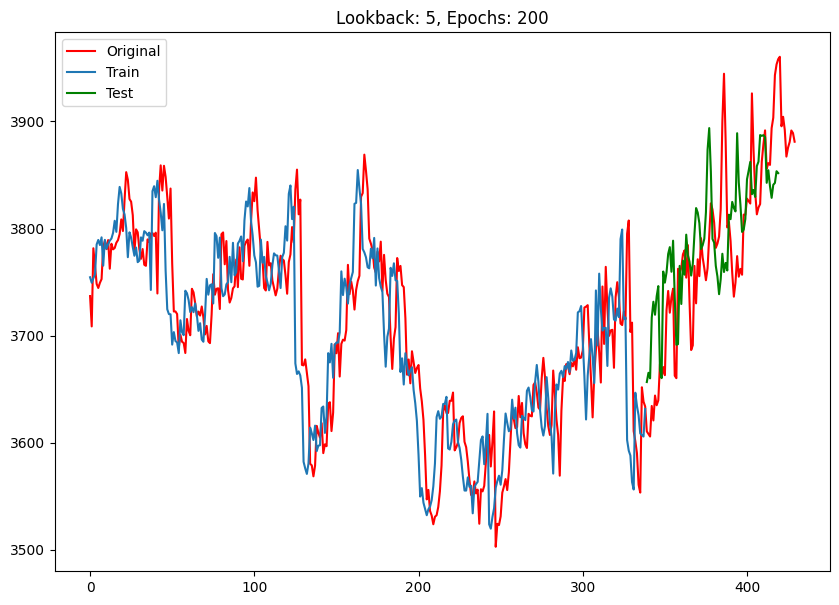

In [26]:
model.eval()
with torch.no_grad():
    train_outputs = []
    for X, _ in train_loader:
        X = X.to(device)
        y_pred = model(X)
        train_outputs.append(y_pred.cpu().numpy())

    train_outputs = np.concatenate(train_outputs)

test_outputs = []
with torch.no_grad():
    for X, _ in test_loader:
        X = X.to(device)
        y_pred = model(X)
        test_outputs.append(y_pred.cpu().numpy())

test_outputs = np.concatenate(test_outputs)

#multiplying back the mean and standard deviation, essentially undoing the normalization before plotting
plt.figure(figsize=(10, 7))
plt.plot(range(len(np_arr)), np_arr*std+mean, label="Original", c="r")
plt.plot(range(len(train_outputs)), train_outputs*std+mean, label="Train")
plt.plot(range(len(train_outputs), len(train_outputs) + len(test_outputs)), test_outputs*std+mean, label="Test", c="g")
plt.title(f"Lookback: {lookback}, Epochs: {num_epoch}")
plt.legend()
plt.show()

In [27]:
y_test2= y_test*std+mean
test_outputs2= test_outputs*std+mean

from sklearn.metrics import mean_squared_error, r2_score
y_test_np = y_test2.detach().numpy()
l1_loss = torch.nn.L1Loss()(torch.from_numpy(test_outputs2), y_test2).item()
r_squared = r2_score(y_test_np, test_outputs2)
rmse = np.sqrt(mean_squared_error(y_test_np, test_outputs2))
print(f"MAE Loss: {l1_loss}")
print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

MAE Loss: 30.054412841796875
R-squared: 0.7084521055221558
RMSE: 39.515124551991164


# CNN-LSTM 3

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def prepare_stock_data(df, sequence_length=60):
 
    df = df.sort_index()
    
    feature_columns = ['Open', 'Close', 'Change', 'sentiment', 'sentiment_score']
    
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    scaled_features = feature_scaler.fit_transform(df[feature_columns])
    
    scaled_target = target_scaler.fit_transform(df[['Close']])
    
    X, y = [], []
    
    # Create sequences
    for i in range(len(df) - sequence_length):
        X.append(scaled_features[i:(i + sequence_length)])
        y.append(scaled_target[i + sequence_length])
    
    return np.array(X), np.array(y), (feature_scaler, target_scaler)

def create_model(sequence_length, n_features):
    
    model = Sequential([
        # CNN layers
        Conv1D(filters=64, kernel_size=3, activation='relu', 
               input_shape=(sequence_length, n_features)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # LSTM layers
        LSTM(units=50, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(units=50),
        BatchNormalization(),
        Dropout(0.2),
        
        
        Dense(50, activation='relu'),
        Dense(1, activation='linear')
    ])
    
   
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse',
                 metrics=['mae'])
    
    return model


df = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv', index_col='Date', parse_dates=True)


sequence_length = 10 
n_features = 5  


X, y, scalers = prepare_stock_data(df, sequence_length=sequence_length)
feature_scaler, target_scaler = scalers


train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


model = create_model(sequence_length, n_features)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

predictions = model.predict(X_test)

predictions = target_scaler.inverse_transform(predictions)
actual_values = target_scaler.inverse_transform(y_test)


Epoch 1/100
9/9 [==============================] - 5s 103ms/step - loss: 0.8902 - mae: 0.7266 - val_loss: 0.2506 - val_mae: 0.4707
Epoch 2/100
9/9 [==============================] - 0s 10ms/step - loss: 0.4599 - mae: 0.5387 - val_loss: 0.2350 - val_mae: 0.4539
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.3943 - mae: 0.4783 - val_loss: 0.2211 - val_mae: 0.4383
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 0.2857 - mae: 0.4205 - val_loss: 0.2116 - val_mae: 0.4272
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 0.2930 - mae: 0.4290 - val_loss: 0.2140 - val_mae: 0.4299
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 0.2401 - mae: 0.3748 - val_loss: 0.2136 - val_mae: 0.4295
Epoch 7/100
9/9 [==============================] - 0s 9ms/step - loss: 0.2149 - mae: 0.3645 - val_loss: 0.2122 - val_mae: 0.4278
Epoch 8/100
9/9 [==============================] - 0s 9ms/step - loss: 0.1743 - mae: 0.3332 -

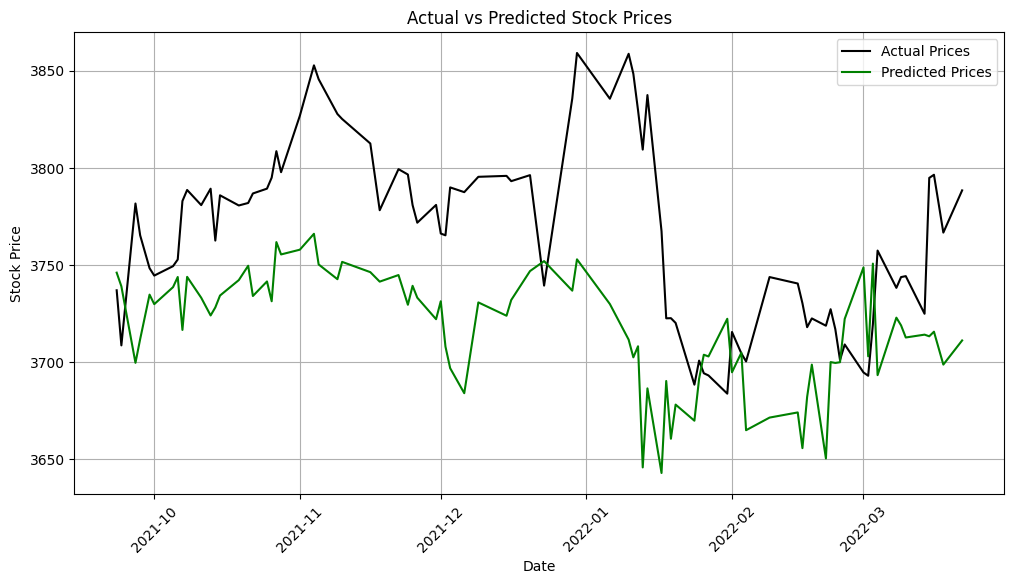

Mean Absolute Error (MAE): 54.414825753348225
Root Mean Squared Error (RMSE): 65.3888536214984
R-squared (R2): -1.0541742954992013


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute Evaluation Metrics
mae = mean_absolute_error(actual_values, predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
r2 = r2_score(actual_values, predictions)

test_dates = df.index[-len(actual_values):] 

plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_values, label="Actual Prices", color='black')
plt.plot(test_dates, predictions, label="Predicted Prices", color='green')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)